In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque 
from random import random, sample, randint

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tic_env import TictactoeEnv, OptimalPlayer

In [3]:
def valid_move(grid, move):
    return grid[(move//3,move%3)] == 0

class DeepQLearner:

    def __init__(self, network, replayBuffer, epsilon=0.1):
        self.epsilon=epsilon
        
        self.model = network
        self.replayBuffer =  replayBuffer 
        self.last_state = None
        self.last_action = None
        
    def start_game(self):
        self.last_state = None
        self.last_action = None
            
    
    def act(self, grid, add_to_buffer=True):
        move = self._act_random(grid) if random()<self.epsilon else self._act_optimal(grid)
        
        if add_to_buffer:
            self.push(grid,0)
        self.last_state = grid
        self.last_action = move
        return move
    
    
    def update_epsilon(self, new_epsilon):
        self.epsilon = new_epsilon
    
    def _act_optimal(self, grid):
        with torch.no_grad():
            actions_reward = self.model(grid_to_state(grid))
            return torch.argmax(actions_reward).item()
        
        
    def _act_random(self, grid):
        actions = [i for i in range(9) if valid_move(grid,i)]
        return actions[randint(0,len(actions)-1)]
    
    def update_qvalue_end(self, reward=0):
        ### shall we add the end state
        self.push(None, reward)
    
    def push(self, state, reward):
        if self.last_action is not None and self.last_state is not None:
            self.replayBuffer.push( self.last_state, self.last_action, state, reward)

def network():
    return nn.Sequential(nn.Linear(9*2,128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128,128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128,9))

def grid_to_state(grid):
    return torch.tensor(np.stack([grid>0,grid<0])).float().view(1,-1)

#######from pytroch tutorial
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
def train_deep_q_player(deep_epsilon=0.1, optimal_epsilon=0.5, buffer_size=10000, batch_size=64, nb_games = 20000, update_length = 500, average_length = 250.0):
    Turns = np.array(['X','O'])
    
    policy_net = network()
    target_net = network()
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    replayBuffer = ReplayMemory(buffer_size)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
    criterion = nn.HuberLoss()
    
    deep_q = DeepQLearner(policy_net, replayBuffer, epsilon=deep_epsilon)
    optimal = OptimalPlayer(epsilon=0.5, player=Turns[0])

    optimize_deep_q_player = lambda transitions : update_deep_q_player(policy_net, target_net, transitions ,  optimizer, criterion, batch_size = batch_size, gamma=0.99)
    
    average_loss = []
    average_reward = []
 
    
    rewards = 0
    loss = 0
  
    for i in tqdm(range(nb_games)):
        optimal.player = Turns[np.mod(i,2)]
        
        (loss_, reward_) = train_on_a_game(optimal, deep_q, Turns[np.mod(i+1,2)], optimize_deep_q_player, replayBuffer, batch_size)
        
        loss += sum(loss_)/len(loss_) if len(loss_)>0 else 0
        rewards += reward_
        
        
        if np.mod(i+1,update_length) == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if np.mod(i+1,average_length) == 0:
            average_loss.append(loss/average_length)
            average_reward.append(rewards/average_length)
            loss = 0
            rewards = 0
           
    return average_loss, average_reward


def train_on_a_game(optimal, deep_q, deep_q_turn, update_deep_q_player, replayBuffer, batch_size):
    env = TictactoeEnv()
    deep_q.start_game()
    grid, _, __ = env.observe()
    losses = []
    
    for j in range(9):
            
            if env.current_player == deep_q_turn:
                move =  deep_q.act(grid)
            else:
                move = optimal.act(grid)
                move = move[0]*3+move[1]
            
            
            if not valid_move(grid,move):
                ## je crois que c'est juste
                deep_q.update_qvalue_end(-1)
                return losses, -1
            
            ###tester if buffer has enough samples
            if len(replayBuffer)>=batch_size:
                transitions = replayBuffer.sample(batch_size)
                losses.append(update_deep_q_player(transitions))
                
            grid, end, winner = env.step(move, print_grid=False)
            
 
            
            if end:
                    
                reward = env.reward(player=deep_q_turn)
                deep_q.update_qvalue_end(reward)
                return losses, reward
                

def update_deep_q_player(policy_net, target_net, transitions , optim, criterion, batch_size, gamma=0.99):
    ##### inspired from :: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
  
   
    
    state_batch = torch.cat(list(map(lambda x : grid_to_state(x), batch.state)))
    action_batch = torch.tensor(batch.action).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward).unsqueeze(1)

 

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    with torch.no_grad():
        next_state_values = torch.zeros(batch_size)
        
        non_none_states = [grid_to_state(s) for s in batch.next_state if s is not None]
        if len(non_none_states)>0:
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool) 
            non_final_next_states = torch.cat(non_none_states) 
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
            
        next_state_values = next_state_values.view((-1,1))
      
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch


    # Compute Huber loss

    loss = criterion(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optim.zero_grad()
    loss.backward()
   
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optim.step()
   
   
    return loss.item()

In [5]:
def compute_M(q_player, epsilon, n_games = 500):
    Turns = np.array(['X','O'])
    env = TictactoeEnv()

    q_player_epsilon = q_player.epsilon
    q_player.update_epsilon(new_epsilon = 0)
    deep_q_turn = Turns[0]
    win_minus_loss = 0
    
    player_opt = OptimalPlayer(epsilon=epsilon, player=Turns[1])
    
    for i in range(n_games):
        q_player.start_game()
        grid, _, __ = env.observe()
        
        #QPlayer plays first for the first 250 games and we switch to the optimal player after n_games/2 games
        if i == n_games//2 :
            player_opt.player = Turns[0]
            deep_q_turn = Turns[1]
        
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
                move = move[0]*3+move[1]
            else:
                with torch.no_grad():
                    move = q_player.act(grid, add_to_buffer=False)
            
           
            if not valid_move(grid,move):
                win_minus_loss -= 1
                env.reset()
                break

            grid, end, winner = env.step(move, print_grid=False)
        
           

            if end:
                win_minus_loss += env.reward(player=deep_q_turn)
                        
                env.reset()
                break
    
    q_player.update_epsilon(new_epsilon = q_player_epsilon)
    return (win_minus_loss)/n_games

In [6]:
def epsilon(n, n_star, epsilon_min = 0.1, epsilon_max = 0.8):
    return np.maximum(epsilon_min, epsilon_max*(1-n/n_star))

def train_deep_q_epsilon_star(n_star=1, optimal_epsilon=0.5, buffer_size=10000, batch_size=64, nb_games = 20000, update_length = 500, average_length = 250.0):
    Turns = np.array(['X','O'])
    
    policy_net = network()
    target_net = network()
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    replayBuffer = ReplayMemory(buffer_size)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
    criterion = nn.HuberLoss()
    
    deep_q = DeepQLearner(policy_net, replayBuffer, epsilon=0)
    optimal = OptimalPlayer(epsilon=0.5, player=Turns[0])

    optimize_deep_q_player = lambda transitions : update_deep_q_player(policy_net, target_net, transitions ,  optimizer, criterion, batch_size = batch_size, gamma=0.99)
    
    M_opts =  []
    M_rands = [] 
  
  
    for i in tqdm(range(nb_games)):
        optimal.player = Turns[np.mod(i,2)]
        
        deep_q.update_epsilon(new_epsilon = epsilon(i, n_star))
        train_on_a_game(optimal, deep_q, Turns[np.mod(i+1,2)], optimize_deep_q_player, replayBuffer, batch_size)
        
        
        if np.mod(i+1,update_length) == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if np.mod(i+1,average_length) == 0:
            M_opts.append(compute_M(deep_q,0))
            M_rands.append(compute_M(deep_q,1))
           
           
    return M_opts, M_rands

In [12]:
e_opts = [0.0, 0.1, 0.3, 0.6, 0.8, 1.0]
M_opts, M_rands =  {}, {}
n_star = 16000

for e_opt in e_opts:
    M_opt, M_rand = train_deep_q_epsilon_star(n_star=n_star, optimal_epsilon=e_opt, nb_games = 20000, average_length = 250)
    M_opts[e_opt] = M_opt
    M_rands[e_opt] = M_rand

100%|█████████████████████████████████████| 20000/20000 [18:59<00:00, 17.55it/s]


In [21]:
import pickle
filename = './save_question_14'
outfile = open(filename,'wb')
pickle.dump({'M_opts':M_opts, 'M_rands':M_rands}, outfile)
outfile.close()

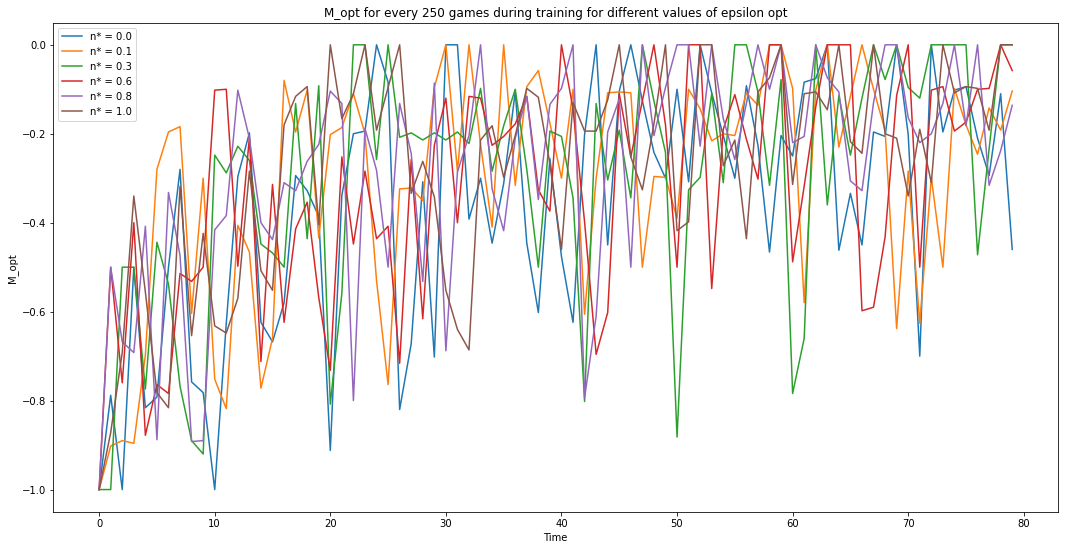

In [13]:
fig = plt.figure(figsize=(18,9))
for n_star, m_opt in M_opts.items():
    y = m_opt
    plt.plot(range(len(y)), y, label = 'n* = ' + str(n_star))
plt.legend()
plt.title('M_opt for every 250 games during training for different values of epsilon opt')
plt.ylabel('M_opt')
plt.xlabel('Time')
plt.show()

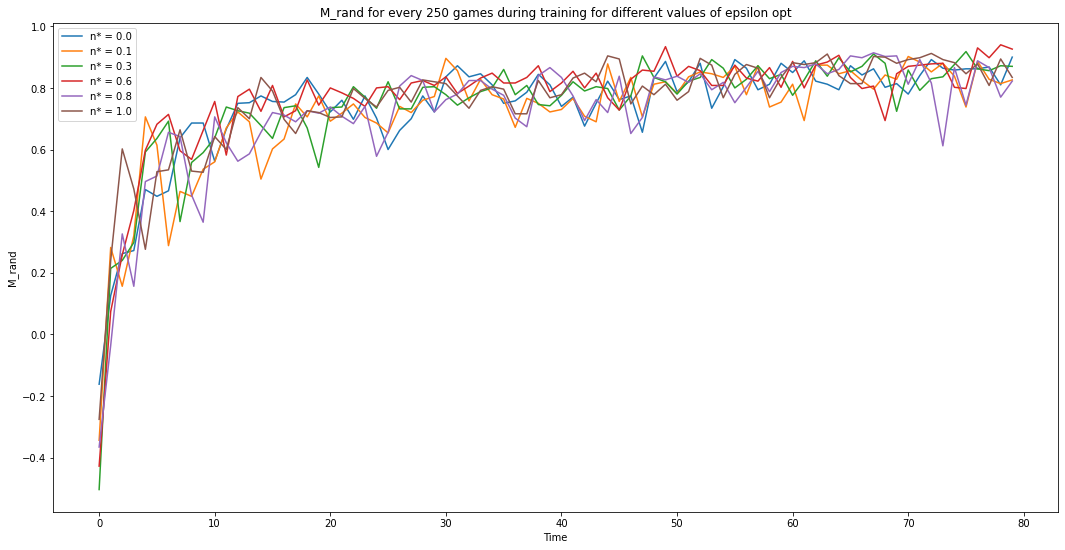

In [14]:
fig = plt.figure(figsize=(18,9))
for n_star, m_rand in M_rands.items():
    y = m_rand
    plt.plot(range(len(y)), y, label = 'n* = ' + str(n_star))
plt.legend()
plt.title('M_rand for every 250 games during training for different values of epsilon opt')
plt.ylabel('M_rand')
plt.xlabel('Time')
plt.show()

In [15]:
for epsilon, m_opt in M_opts.items():
    print(f'epsilon opt : {epsilon} {m_opt[-1]}')

epsilon opt : 0.0 -0.46
epsilon opt : 0.1 -0.104
epsilon opt : 0.3 0.0
epsilon opt : 0.6 -0.058
epsilon opt : 0.8 -0.136
epsilon opt : 1.0 0.0


In [16]:
for epsilon, m_rand in M_rands.items():
    print(f'epsilon opt : {epsilon} {m_rand[-1]}')

epsilon opt : 0.0 0.9
epsilon opt : 0.1 0.826
epsilon opt : 0.3 0.87
epsilon opt : 0.6 0.926
epsilon opt : 0.8 0.822
epsilon opt : 1.0 0.834


In [24]:
best_epsilon_m_opt = 0.3
best_epsilon_m_rand = 0.6
final_performance_m_opt =  M_opts[best_epsilon_m_opt][-1]
final_performance_m_rand = M_rands[best_epsilon_m_rand][-1]
training_time_m_opt = first_index_greater(M_opts[best_epsilon_m_opt], 0.8*final_performance_m_opt)*250
training_time_m_rand = first_index_greater(M_rands[best_epsilon_m_rand], 0.8*final_performance_m_rand)*250

print(f'training time m_opt {training_time_m_opt} training time m_rand {training_time_m_rand}')

training time m_opt 5500 training time m_rand 2500


In [27]:
def training_time_m_opt(values):
    values = np.array(values)+1
    last = values[-1]
    
    return np.argmax(values>=last*0.8)+1

def training_time_m_rands(values):
    values = np.array(values)
    last = values[-1]
    
    return np.argmax(values>=last*0.8)+1

In [28]:
training_time_m_opt([-1,-0.4,-0.5,-0.1,0])

4